<a href="https://colab.research.google.com/github/iHarshMix/CNN-MNIST-98perc/blob/main/mnistCNN98percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



# 1️⃣ Data transforms (MNIST standard normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2️⃣ Load datasets
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform),
                         batch_size=128, shuffle=False)

# 3️⃣ Compact CNN model
class FastCNN(nn.Module):
    def __init__(self):
        super(FastCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)   # 28x28 -> 26x26
        self.conv2 = nn.Conv2d(16, 32, 3, 1)  # 26x26 -> 24x24
        self.pool = nn.MaxPool2d(2)           # 24x24 -> 12x12
        self.fc1 = nn.Linear(32*12*12, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 4️⃣ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastCNN().to(device)

# 5️⃣ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6️⃣ Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# 7️⃣ Evaluate test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.23MB/s]


Epoch 1, Loss: 0.1824
Epoch 2, Loss: 0.0518
Epoch 3, Loss: 0.0361
Test Accuracy: 98.76%


In [2]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.76%


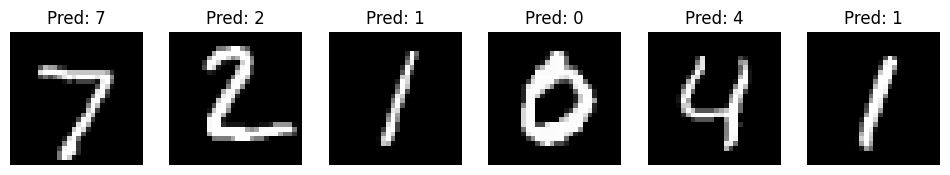

In [3]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {predicted[i].item()}')
    axes[i].axis('off')
plt.show()
